In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision 
import torchvision.transforms as transforms
from collections import OrderedDict
import time
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datetime import datetime

In [2]:
n_epochs = 10
mini_batch_size = 128
learning_rate = 0.01
momentum = 0.9
log_interval = 10

In [3]:
train_transforms = transforms.Compose([\
                transforms.Resize((32,32)),\
                transforms.ToTensor(),\
                transforms.Normalize(mean = (0.1307,), std = (0.3081,))\
])

test_transforms = transforms.Compose([\
                transforms.Resize((32,32)),\
                transforms.ToTensor(),\
                transforms.Normalize(mean = (0.1325,), std = (0.3105,))\
])

train_loader = DataLoader(torchvision.datasets.MNIST('data/',train=True, download=True, transform=train_transforms),batch_size=mini_batch_size)

test_loader = DataLoader(torchvision.datasets.MNIST('data/',train=False, download=True, transform=test_transforms), batch_size=mini_batch_size)

In [ ]:
train_loader.dataset

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.convnet = nn.Sequential(OrderedDict([
            ('c1' , nn.Conv2d(1,6, kernel_size=(5,5),) ),
            ('relu1', nn.ReLU()),
            ('s2', nn.MaxPool2d(kernel_size=(2,2), stride=2)),
            ('c3', nn.Conv2d(6, 16, kernel_size=(5,5), )),
            ('relu2' , nn.ReLU()),
            ('s4', nn.MaxPool2d(kernel_size=(2,2), stride=2)) ,
            ('c5', nn.Conv2d(16, 120, kernel_size=(5,5)) ),
            ('relu3', nn.ReLU() ),]
        ))
        self.fc = nn.Sequential(OrderedDict([
            ('f6', nn.Linear(120, 84) ),
            ('relu6', nn.ReLU() ),
            ('f7', nn.Linear(84,10) ),
            ('sig7', nn.LogSoftmax(dim=-1) )
            ]
        ))


    def forward(self, x):
        out = self.convnet(x)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)

        return out


In [5]:
class ClassifierTraining:

    def __init__(self, classifer_model, train_loader: DataLoader, test_loader: DataLoader, prune_version=None):
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = classifer_model.to(self.device)
        # self.model.to(self.device)
        self.optimizer = optim.SGD(self.model.parameters(), lr=learning_rate, momentum=momentum)
        self.train_losses = []
        self.train_counter = []
        self.test_counter = []
        self.test_losses = []
        self.train_loader = train_loader
        self.test_loader = test_loader
        if prune_version is None:
            self.version = 'base' 

    def train(self, epoch, verbose=True):
        print(self.device)
        os.makedirs('results/',exist_ok=True)

        for batch_idx, (data,target) in enumerate(train_loader):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = F.nll_loss(output, target) # cross entropy loss
            loss.backward()
            self.optimizer.step()
            if batch_idx % log_interval == 0:
                if verbose:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(self.train_loader.dataset),\
                        100. * batch_idx / len(self.train_loader), loss.item()))
                self.train_losses.append(loss.item())
                self.train_counter.append(
                    (batch_idx * 128) + ((epoch - 1) * len(self.train_loader.dataset)))
                torch.save(self.model.state_dict(), f'results/model_{self.version}.pth')
                torch.save(self.optimizer.state_dict(), f'results/optimizer_{self.version}.pth')
    def test(self):
        self.model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                test_loss += F.nll_loss(output, target, size_average=True).item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()

        test_loss /= len(self.test_loader.dataset)
        self.test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(self.test_loader.dataset),
            100. * correct / len(self.test_loader.dataset)))

    def train_model(self,n_epoch):
        train_start_dt = datetime.now()
        self.test_counter = [i * len(self.train_loader.dataset) for i in range(n_epoch)]

        for ep in range(1, n_epoch+1):
            self.train(ep)
            self.test()
        train_end_dt = datetime.now()
        train_duration = (train_end_dt-train_start_dt)

        print(f"Total Training Time : {train_duration}")
        self.plot_train_test()

    def plot_train_test(self):
        fig = plt.figure()
        plt.plot(self.train_counter, self.train_losses, color='blue')
        plt.scatter(self.test_counter, self.test_losses, color='red')
        plt.legend(['Training Loss', 'Test Loss'], loc='upper right')
        plt.xlabel('No of Training Samples')
        plt.ylabel('Loss Function (NLL)')
        fig.savefig(f'results/training_curve_{self.version}.png')

cuda
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.317078
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.295381
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.285659
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.263448
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.241952
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.153364
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.844160
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.887497
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.947423
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.928755
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.527183
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.504641
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.345081
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.472471
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.271493
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.272588
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.250357
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.125136
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.384504
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.133758
Train Epoch

E:\Workspace\HackRU2024\project-env\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0007, Accuracy: 9723/10000 (97%)

cuda
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.078699
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.172896
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.117142
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.058971
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.099554
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.054184
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.077930
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.042557
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.255134
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.133136
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.047305
Train Epoch: 2 [14080/60000 (23%)]	Loss: 0.057910
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.128977
Train Epoch: 2 [16640/60000 (28%)]	Loss: 0.206558
Train Epoch: 2 [17920/60000 (30%)]	Loss: 0.074332
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.090864
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.068520
Train Epoch: 2 [21760/60000 (36%)]	Loss: 0.052905
Train Epoch: 2 [23040/60000 (38%)]	Loss: 0.042604
Tra

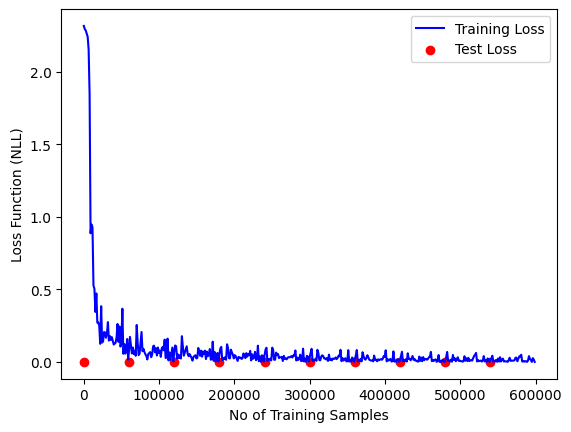

In [6]:
classifer_model = LeNet()
    # print(classifer_model.named_modules() )
classifer = ClassifierTraining(classifer_model=classifer_model, train_loader=train_loader, test_loader=test_loader)
classifer.train_model(n_epoch=n_epochs)

In [7]:
# Show Model State Dictionary
def show_model_layers(model):
    print("Model's state_dict:")
    for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())

def get_total_parameters_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def get_pruned_parameters_count(pruned_model):
    params = 0
    for param in pruned_model.parameters():
        if param is not None:
            params += torch.nonzero(param).size(0)
    return params

In [8]:
'''
Results of LeNet on MNIST (UnPruned) -- Using GPU CUDA:0 
NVIDIA RTX 3050
Test set: Avg. loss: 0.0004, Accuracy: 9862/10000 (99%)
Total Training Time : 0:02:41.521089
[
    ('convnet.c1.weight', 150), 
    ('convnet.c1.bias', 6), 
    ('convnet.c3.weight', 2400), 
    ('convnet.c3.bias', 16), 
    ('convnet.c5.weight', 48000), 
    ('convnet.c5.bias', 120), 
    ('fc.f6.weight', 10080), 
    ('fc.f6.bias', 84), 
    ('fc.f7.weight', 840), 
    ('fc.f7.bias', 10)]
Trainable Parameters = 61706
'''

show_model_layers(classifer_model)
original_param_count = get_total_parameters_count(classifer_model)

Model's state_dict:
convnet.c1.weight 	 torch.Size([6, 1, 5, 5])
convnet.c1.bias 	 torch.Size([6])
convnet.c3.weight 	 torch.Size([16, 6, 5, 5])
convnet.c3.bias 	 torch.Size([16])
convnet.c5.weight 	 torch.Size([120, 16, 5, 5])
convnet.c5.bias 	 torch.Size([120])
fc.f6.weight 	 torch.Size([84, 120])
fc.f6.bias 	 torch.Size([84])
fc.f7.weight 	 torch.Size([10, 84])
fc.f7.bias 	 torch.Size([10])
